In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import proplot as pplt
import pandas as pd
import numpy as np
import grid_points as gp
import shading_masks as sm
import sys
import cv2
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
# import workbench
from workbench.utilities import io
from workbench.manage import manage
from workbench.manage import host
# from workbench.workflows import workflows
# from workbench.simulations import method_iv_solver, method_topology_solver, method_module_iv
# from workbench.visualize import plots as ipv_plot
# from workbench.device import temperature

In [3]:
# because we have restarted our notebook we will reactivate our project by reading in the config path
# place your config path here
config_path = "/Users/jmccarty/Nextcloud/Projects/17_framework/cactus_framework_study/cactus_framework_study.config"
project_manager = manage.Project(config_path)

# rerun the setup in order to rebuild the entire project object and its attributes
project_manager.project_setup()

# set the analysis period to 1 hour of the year, it does not matter which hour
project_manager.edit_cfg_file("analysis", "analysis_period", "10-11")


print(project_manager.analysis_device_id)
project_manager.edit_cfg_file("analysis", "analysis_period", "4332-4333")
print(project_manager.analysis_device_id)

# load building
radiance_surface_key = "1111_0"
building = host.Host(project_manager)
sensor_pts_xyz_arr = io.load_grid_file(building.project, radiance_surface_key)[['X', 'Y', 'Z']].values


Destination file already exists, copy aborted./n/Users/jmccarty/Nextcloud/Projects/17_framework/cactus_framework_study/inputs/shared/tmy/base.epw
Destination file already exists, copy aborted./n/Users/jmccarty/Nextcloud/Projects/17_framework/cactus_framework_study/inputs/hosts/B1111/base/geometry/0_cactus_geometry_template.3dm
Destination file already exists, copy aborted./n/Users/jmccarty/Nextcloud/Projects/17_framework/cactus_framework_study/inputs/hosts/B1111/base/geometry/0_cactus_geometry_template.gh
Destination file already exists, copy aborted./n/Users/jmccarty/Nextcloud/Projects/17_framework/cactus_framework_study/inputs/hosts/B1111/base/geometry/1_cactus_panelizer_template.gh
The project is initialized. We have created a base host object named 'B1111'.
You will need to either move or create the geometry and panelizer files into the appropriate directories.
The geometry files should follow the convention defined in the output of the template grasshopper and rhino files.
The pan

In [4]:
module_ctr_points = []
surface = "{1111;0}"
for module in building.get_modules("{1111;0}"):
    module_ctr_points.append(building.get_dict_instance([surface, module])['Details']['panelizer_center_pt'])

module_ctr_points = np.array(module_ctr_points)


In [9]:
min_x = pd.DataFrame(sensor_pts_xyz_arr)[0].min()
max_x = pd.DataFrame(sensor_pts_xyz_arr)[0].max()
min_z = pd.DataFrame(sensor_pts_xyz_arr)[2].min()
max_z = pd.DataFrame(sensor_pts_xyz_arr)[2].max()

x_dim = max_x - min_x
y_dim = max_z - min_z

# Grids

In [39]:
grid_codes = ['a1','a2','a3','a4','b1','b2','c1','c2']
for og_grid_code in grid_codes:
    if og_grid_code[0] == "c":
        grid_code = "b" + str(og_grid_code[1])
    else:
        grid_code = og_grid_code
    pts = gp.generate_grid_points(sensor_pts_xyz_arr, grid_code, building,
                                        radiance_surface_key)
    
    print(grid_code,pts.shape[0])

a1 1
a2 12
a3 100
a4 100
b1 84
b2 5040
b1 84
b2 5040


In [ ]:
grid_codes = ['a1','a2','a3','a4','b1','b2','c1','c2']
cell_dim = .035

min_x = pd.DataFrame(sensor_pts_xyz_arr)[0].min()
max_x = pd.DataFrame(sensor_pts_xyz_arr)[0].max()
min_z = pd.DataFrame(sensor_pts_xyz_arr)[2].min()
max_z = pd.DataFrame(sensor_pts_xyz_arr)[2].max()

x_dim = max_x - min_x
y_dim = max_z - min_z

for og_grid_code in grid_codes:
    if og_grid_code[0] == "c":
        grid_code = "b" + str(og_grid_code[1])
    else:
        grid_code = og_grid_code
    pts = gp.generate_grid_points(sensor_pts_xyz_arr, grid_code, building,
                                        radiance_surface_key)
    # pts = module_ctr_points
    
    fig, axe = pplt.subplots(refwidth=8, refaspect=x_dim / y_dim)
    ax =axe[0]

    if grid_code[0]=='a':
        ax.scatter(pts[:,0], pts[:,2], c='k', s=10)
    elif grid_code[0]=='b':
        if og_grid_code[1]=="2":
            ax.scatter(pts[:,0]-min_x+cell_dim, pts[:,2]-min_z+cell_dim, c='k', s=10)
        else:
            ax.scatter(pts[:,0]-min_x, pts[:,2]-min_z, c='k', s=10)
    else:
        if og_grid_code[1]=="2":
            ax.scatter(pts[:,0]-min_x+cell_dim, pts[:,2]-min_z+cell_dim, c='k', s=10)
        else:
            ax.scatter(pts[:,0]-min_x, pts[:,2]-min_z, c='k', s=10)
            
    ax.minorticks_off()
    ax.grid(linestyle='dashed')
    tickbool = False
    ax.tick_params(direction='in',pad=4.25,
                left=tickbool,top=tickbool,right=tickbool,bottom=tickbool,
                )
    ax.format(xlim=(0,19.11),
            ylim=(0,max_z),
            xlocator=1.5925,
            ylocator=0.9825,
            xticklabels='none',
            yticklabels='none')
    if og_grid_code[0]!="c":
        ax.grid(False)
    fig.savefig(f"/Users/jmccarty/GitHub/papers/modeling_framework_paper/figures/frameworks/grid_{og_grid_code}.png",dpi=144)


# Shading Masks

In [4]:
shape_library = ['rows', 'columns', 'rectangle', 'triangle', 'circle', 'ellipse', 'random_squares_small','random_squares_large', 'organic']

In [25]:
np.arange(0.2,0.91,0.20)

array([0.2, 0.4, 0.6, 0.8])

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

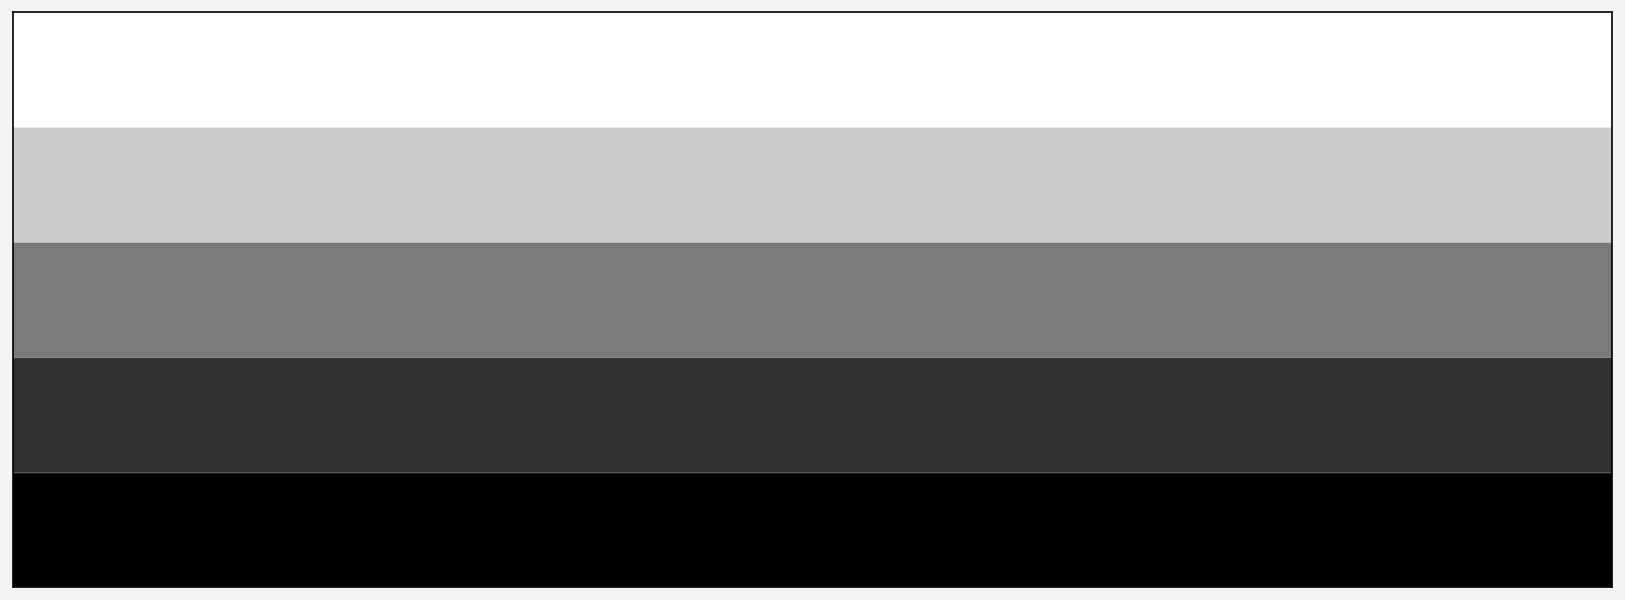

In [32]:
for shape in shape_library[0:1]:
        mask_arr = sm.generate_mask_arr(
                sensor_pts_xyz_arr, shape, coverage_factor=.10)
        coverage_ranges = np.arange(0.2,0.91,0.20)#np.arange(0.05,0.95,0.10)
        shape_coverages = np.flipud(coverage_ranges.reshape(-1,1)).flatten()
        fig, axe = pplt.subplots(refwidth=8, refaspect=mask_arr.shape[1] / mask_arr.shape[0])
        ax = axe[0]

        for n,shape_coverage in enumerate(shape_coverages):
                
                mask_arr = sm.generate_mask_arr(
                        sensor_pts_xyz_arr, shape, coverage_factor=shape_coverage)
                if n==len(coverage_ranges)-1:
                        alpha = np.where(mask_arr == 0, 0.0, 1.0)  # Set alpha to 0 for cells with value 0, otherwise 1
                else:        
                        alpha = np.where(mask_arr == 0, 0.0, coverage_ranges[n])  # Set alpha to 0 for cells with value 0, otherwise 1
                ax.imshow(mask_arr, cmap="Greys", vmin=0, vmax=1,
                        origin="lower",alpha=alpha)

        ax.minorticks_off()

        tickbool = False
        ax.tick_params(direction='in',pad=4.25,
                left=tickbool,top=tickbool,right=tickbool,bottom=tickbool,
                )
        ax.format(xlim=(0,mask_arr.shape[1]),
                ylim=(0,mask_arr.shape[0]),
                # xlocator=1.5925,
                # ylocator=0.9825,
                xticklabels='none',
                yticklabels='none')
        ax.grid(False)

        # fig.savefig(f"/Users/jmccarty/GitHub/papers/modeling_framework_paper/figures/masks_less/{shape}_mask_growth.png",dpi=144)